<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viDKL_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep kernel learning for data reconstruction and automated experiment
This notebook demonstrates how to use a deep kernel learning with variational inference (viDKL) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (January 2022)*

Installations:

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

Download training data:

In [ ]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [ ]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [ ]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [ ]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

Normalize data:

In [ ]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.2826059331244979


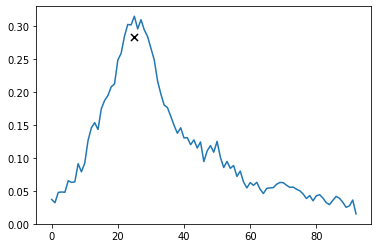

In [ ]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [ ]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

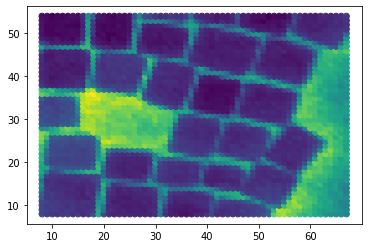

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Train:

In [ ]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X, y, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:07<00:00, 12.56it/s, init loss: 23205.6149, avg. loss [96-100]: 15888.3928]



Inferred GP kernel parameters
k_length         [18.8629  9.8054]
k_scale          0.1381
noise            0.0103


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [ ]:
mean, var = dkl.predict(key2, X)

Text(0.5, 1.0, 'DKL uncertainty')

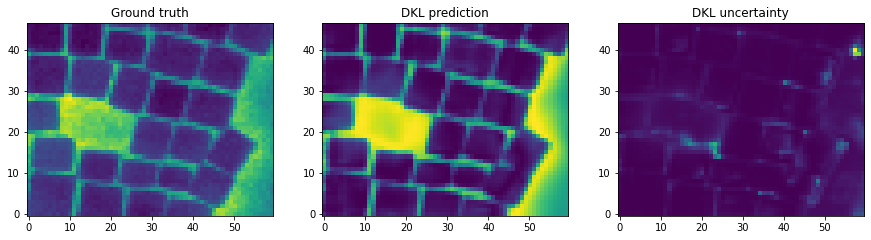

In [ ]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

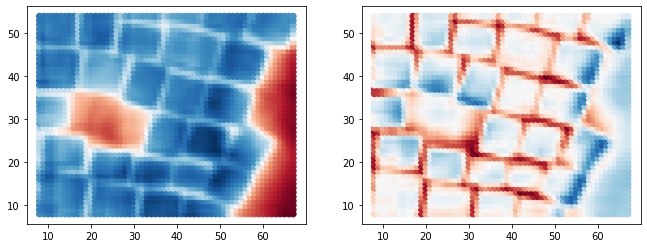

In [ ]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [ ]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [ ]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:03<00:00, 29.04it/s, init loss: 21019.9002, avg. loss [96-100]: 18397.0045]


Inferred GP kernel parameters
k_length         [32.9008 21.674 ]
k_scale          0.1678
noise            0.013000000000000001


In [ ]:
mean, var = dkl.predict(key2, X)

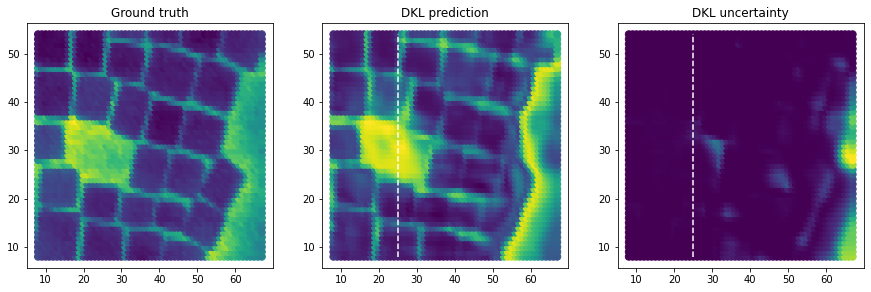

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just a few "measured" points:

In [ ]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

In [ ]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_train)

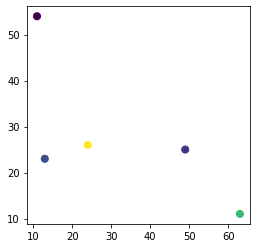

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/80


100%|██████████| 100/100 [00:02<00:00, 40.57it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


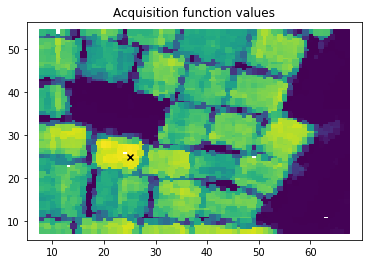

2/80


100%|██████████| 100/100 [00:02<00:00, 35.10it/s, init loss: 20126.0083, avg. loss [96-100]: 19062.0954]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3185
noise            0.1395


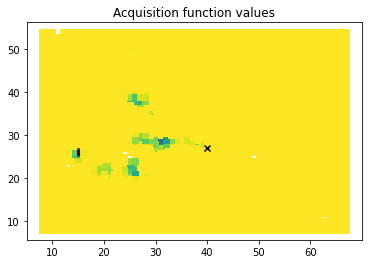

3/80


100%|██████████| 100/100 [00:02<00:00, 39.61it/s, init loss: 20127.2665, avg. loss [96-100]: 19062.2108]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3075
noise            0.1257


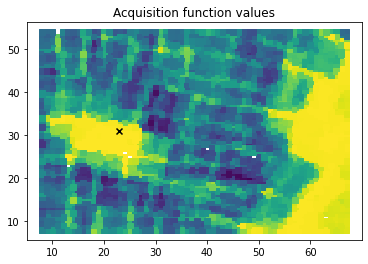

4/80


100%|██████████| 100/100 [00:02<00:00, 37.25it/s, init loss: 20128.6552, avg. loss [96-100]: 19062.5365]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3206
noise            0.1202


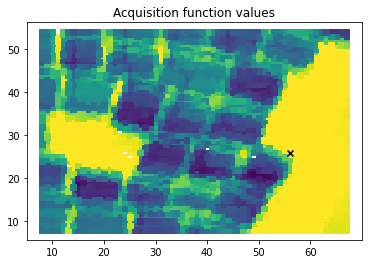

5/80


100%|██████████| 100/100 [00:02<00:00, 35.18it/s, init loss: 20129.8634, avg. loss [96-100]: 19062.6827]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.311
noise            0.11320000000000001


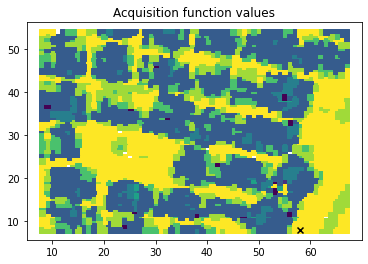

6/80


100%|██████████| 100/100 [00:02<00:00, 37.66it/s, init loss: 20131.2385, avg. loss [96-100]: 19062.8224]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3195
noise            0.1066


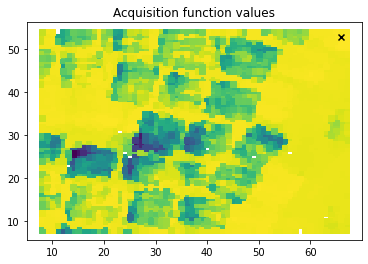

7/80


100%|██████████| 100/100 [00:02<00:00, 38.44it/s, init loss: 20132.4961, avg. loss [96-100]: 19062.9067]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3118
noise            0.1018


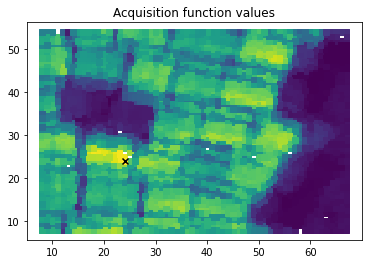

8/80


100%|██████████| 100/100 [00:02<00:00, 35.09it/s, init loss: 20133.8647, avg. loss [96-100]: 19063.1443]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3204
noise            0.10010000000000001


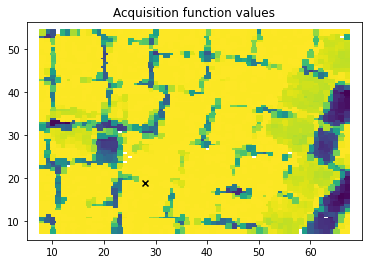

9/80


100%|██████████| 100/100 [00:02<00:00, 37.56it/s, init loss: 20135.1166, avg. loss [96-100]: 19063.2674]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3134
noise            0.0974


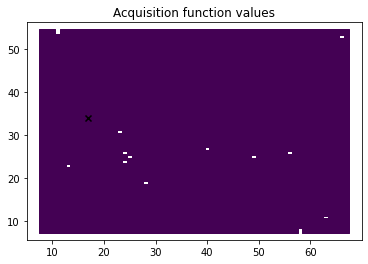

10/80


100%|██████████| 100/100 [00:02<00:00, 36.02it/s, init loss: 20136.5745, avg. loss [96-100]: 19063.9884]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3241
noise            0.10400000000000001


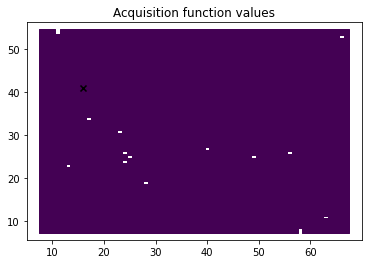

11/80


100%|██████████| 100/100 [00:02<00:00, 36.74it/s, init loss: 20137.8255, avg. loss [96-100]: 19084.8354]



Inferred GP kernel parameters
k_length         [1.3805 0.9966]
k_scale          0.24500000000000002
noise            0.058


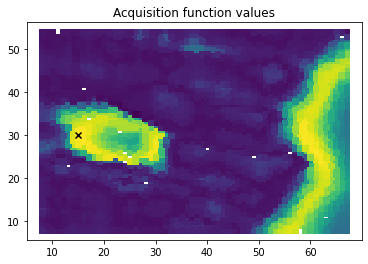

12/80


100%|██████████| 100/100 [00:02<00:00, 34.35it/s, init loss: 20139.0685, avg. loss [96-100]: 19063.9845]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.317
noise            0.0955


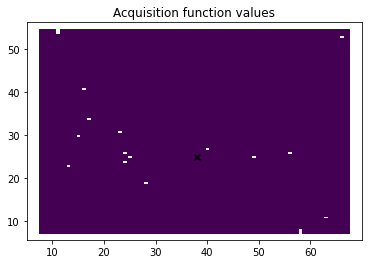

13/80


100%|██████████| 100/100 [00:04<00:00, 24.25it/s, init loss: 20140.2817, avg. loss [96-100]: 19063.9629]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3126
noise            0.09230000000000001


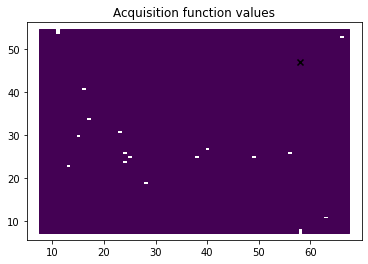

14/80


100%|██████████| 100/100 [00:02<00:00, 34.27it/s, init loss: 20141.5057, avg. loss [96-100]: 19063.9066]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30910000000000004
noise            0.08900000000000001


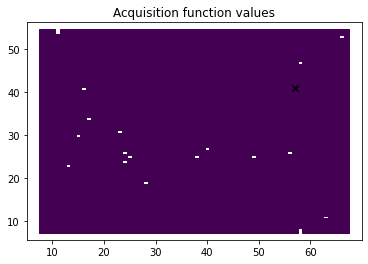

15/80


100%|██████████| 100/100 [00:02<00:00, 35.54it/s, init loss: 20142.7614, avg. loss [96-100]: 19063.8966]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3052
noise            0.0868


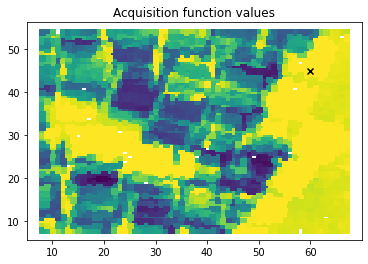

16/80


100%|██████████| 100/100 [00:03<00:00, 32.16it/s, init loss: 20144.0185, avg. loss [96-100]: 19090.1892]



Inferred GP kernel parameters
k_length         [1.6812 1.4854]
k_scale          0.20140000000000002
noise            0.045700000000000005


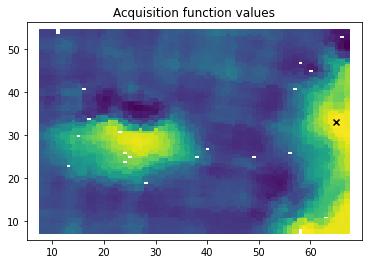

17/80


100%|██████████| 100/100 [00:03<00:00, 31.18it/s, init loss: 20145.3001, avg. loss [96-100]: 19090.4763]



Inferred GP kernel parameters
k_length         [2.0439 1.4441]
k_scale          0.2141
noise            0.0466


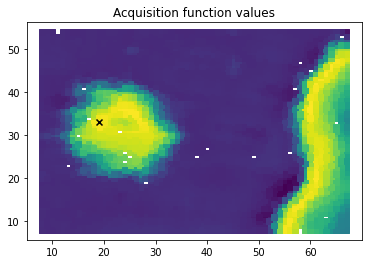

18/80


100%|██████████| 100/100 [00:03<00:00, 33.04it/s, init loss: 20146.7209, avg. loss [96-100]: 19094.8693]



Inferred GP kernel parameters
k_length         [2.3093 2.3173]
k_scale          0.21080000000000002
noise            0.046900000000000004


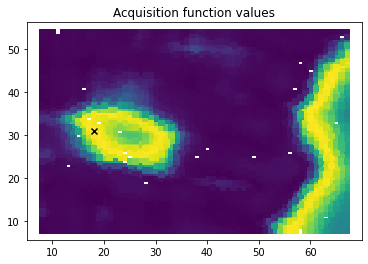

19/80


100%|██████████| 100/100 [00:02<00:00, 34.81it/s, init loss: 20148.1311, avg. loss [96-100]: 19091.3616]



Inferred GP kernel parameters
k_length         [2.0769 1.7158]
k_scale          0.2126
noise            0.0419


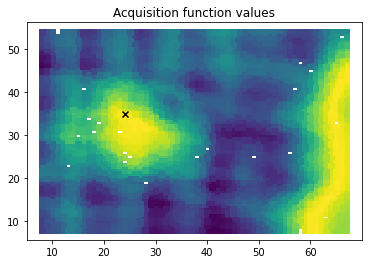

20/80


100%|██████████| 100/100 [00:04<00:00, 20.65it/s, init loss: 20149.5409, avg. loss [96-100]: 19084.9893]



Inferred GP kernel parameters
k_length         [2.1409 2.5394]
k_scale          0.2374
noise            0.0356


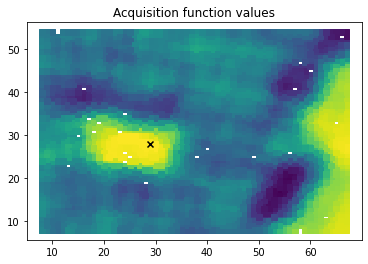

21/80


100%|██████████| 100/100 [00:02<00:00, 33.78it/s, init loss: 20150.8961, avg. loss [96-100]: 19104.5861]



Inferred GP kernel parameters
k_length         [2.4551 2.8173]
k_scale          0.20900000000000002
noise            0.0352


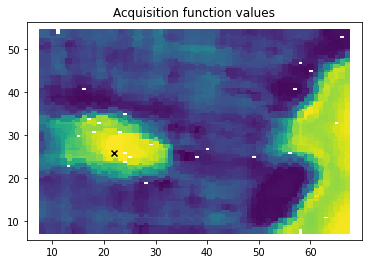

22/80


100%|██████████| 100/100 [00:03<00:00, 32.40it/s, init loss: 20152.3008, avg. loss [96-100]: 19077.2284]



Inferred GP kernel parameters
k_length         [2.0869 1.8732]
k_scale          0.2482
noise            0.0345


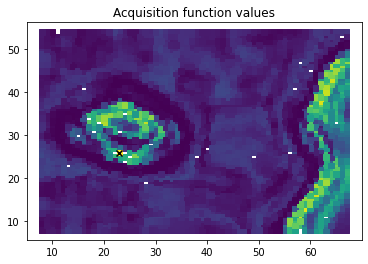

23/80


100%|██████████| 100/100 [00:03<00:00, 33.17it/s, init loss: 20153.6195, avg. loss [96-100]: 19137.9263]



Inferred GP kernel parameters
k_length         [2.7059 2.1649]
k_scale          0.2554
noise            0.0334


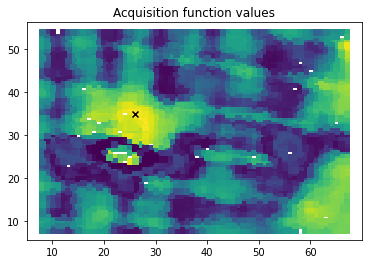

24/80


100%|██████████| 100/100 [00:03<00:00, 26.79it/s, init loss: 20154.9155, avg. loss [96-100]: 19106.6079]



Inferred GP kernel parameters
k_length         [3.3591 3.2992]
k_scale          0.2267
noise            0.0368


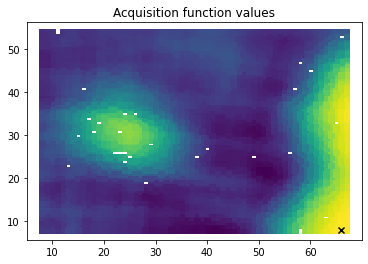

25/80


100%|██████████| 100/100 [00:03<00:00, 32.45it/s, init loss: 20156.2063, avg. loss [96-100]: 19094.2711]



Inferred GP kernel parameters
k_length         [2.9349 3.1355]
k_scale          0.23390000000000002
noise            0.0323


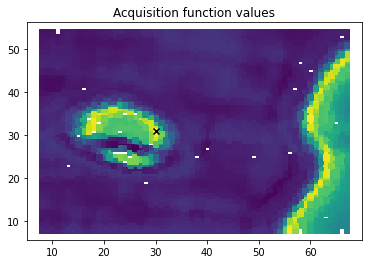

26/80


100%|██████████| 100/100 [00:03<00:00, 30.39it/s, init loss: 20157.5521, avg. loss [96-100]: 19111.2197]



Inferred GP kernel parameters
k_length         [3.2614 3.4853]
k_scale          0.2472
noise            0.0323


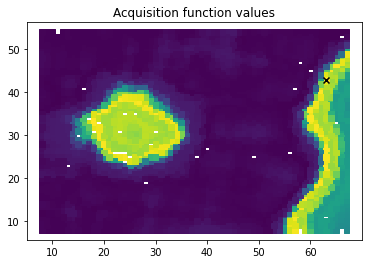

27/80


100%|██████████| 100/100 [00:03<00:00, 28.54it/s, init loss: 20158.9081, avg. loss [96-100]: 19065.9373]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3427
noise            0.083


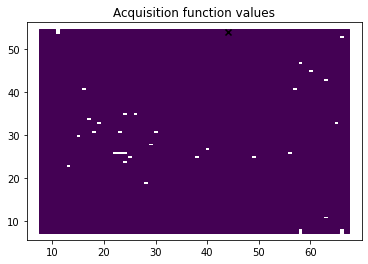

28/80


100%|██████████| 100/100 [00:03<00:00, 31.66it/s, init loss: 20160.1475, avg. loss [96-100]: 19082.0755]



Inferred GP kernel parameters
k_length         [2.2561 4.2837]
k_scale          0.2281
noise            0.027700000000000002


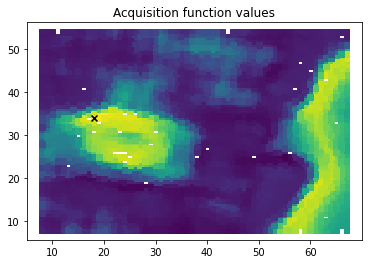

29/80


100%|██████████| 100/100 [00:03<00:00, 32.08it/s, init loss: 20161.5664, avg. loss [96-100]: 19100.7721]



Inferred GP kernel parameters
k_length         [3.0536 3.0164]
k_scale          0.2283
noise            0.0287


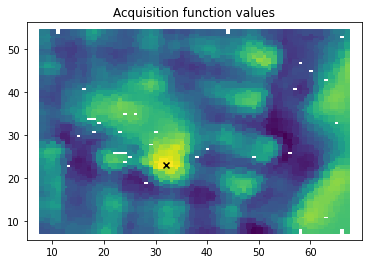

30/80


100%|██████████| 100/100 [00:02<00:00, 35.24it/s, init loss: 20162.9443, avg. loss [96-100]: 19077.9526]



Inferred GP kernel parameters
k_length         [4.0617 4.4849]
k_scale          0.23020000000000002
noise            0.029


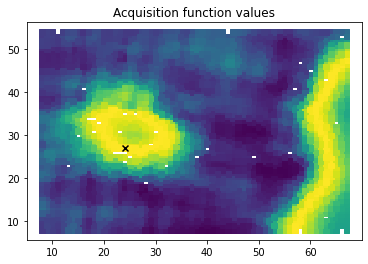

31/80


100%|██████████| 100/100 [00:03<00:00, 31.69it/s, init loss: 20164.2762, avg. loss [96-100]: 19085.6261]



Inferred GP kernel parameters
k_length         [3.045  2.7997]
k_scale          0.2233
noise            0.027700000000000002


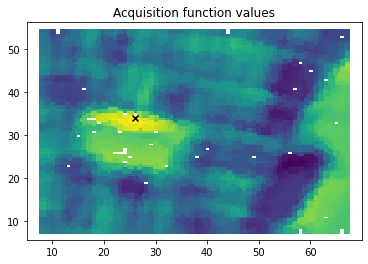

32/80


100%|██████████| 100/100 [00:02<00:00, 35.15it/s, init loss: 20165.5722, avg. loss [96-100]: 19066.7859]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3498
noise            0.0826


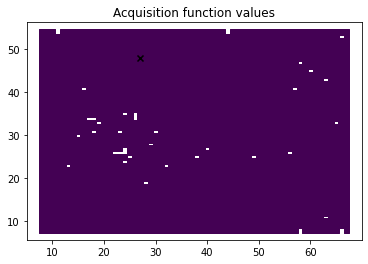

33/80


100%|██████████| 100/100 [00:02<00:00, 34.96it/s, init loss: 20166.7608, avg. loss [96-100]: 19138.7681]



Inferred GP kernel parameters
k_length         [3.8516 3.8697]
k_scale          0.22460000000000002
noise            0.0284


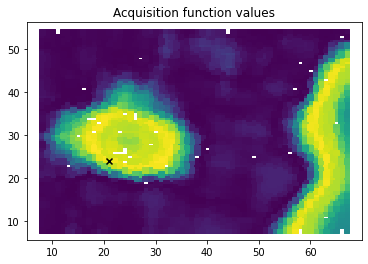

34/80


100%|██████████| 100/100 [00:02<00:00, 35.76it/s, init loss: 20168.0310, avg. loss [96-100]: 19117.1298]



Inferred GP kernel parameters
k_length         [3.7729 5.0414]
k_scale          0.21350000000000002
noise            0.029500000000000002


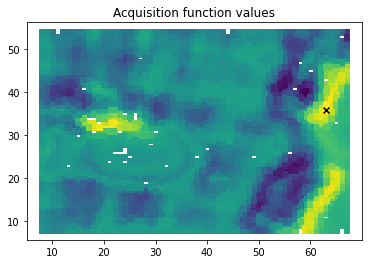

35/80


100%|██████████| 100/100 [00:02<00:00, 35.75it/s, init loss: 20169.3083, avg. loss [96-100]: 19091.5720]



Inferred GP kernel parameters
k_length         [3.5012 4.0794]
k_scale          0.22260000000000002
noise            0.024300000000000002


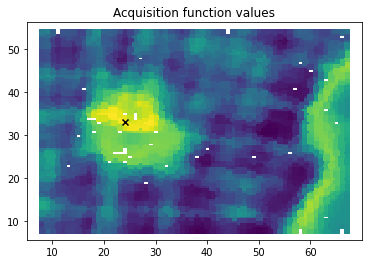

36/80


100%|██████████| 100/100 [00:02<00:00, 34.51it/s, init loss: 20170.5633, avg. loss [96-100]: 19120.1767]



Inferred GP kernel parameters
k_length         [5.1464 3.309 ]
k_scale          0.2154
noise            0.025500000000000002


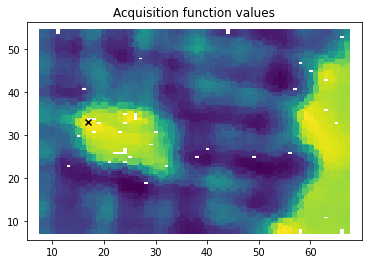

37/80


100%|██████████| 100/100 [00:02<00:00, 35.67it/s, init loss: 20171.8504, avg. loss [96-100]: 19080.8054]



Inferred GP kernel parameters
k_length         [4.2855 3.6457]
k_scale          0.21760000000000002
noise            0.025500000000000002


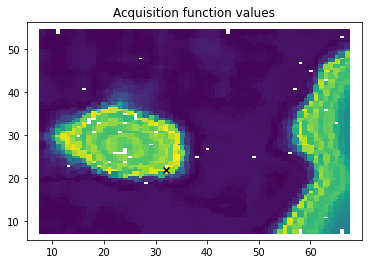

38/80


100%|██████████| 100/100 [00:03<00:00, 30.81it/s, init loss: 20173.2183, avg. loss [96-100]: 19092.2059]



Inferred GP kernel parameters
k_length         [4.5346 4.4085]
k_scale          0.2356
noise            0.0303


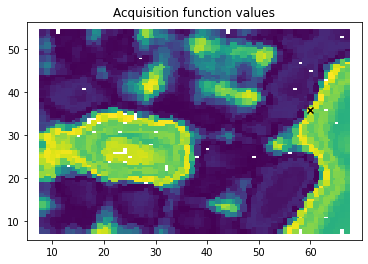

39/80


100%|██████████| 100/100 [00:02<00:00, 35.20it/s, init loss: 20174.5187, avg. loss [96-100]: 19064.9224]



Inferred GP kernel parameters
k_length         [4.0315 4.4861]
k_scale          0.2298
noise            0.022500000000000003


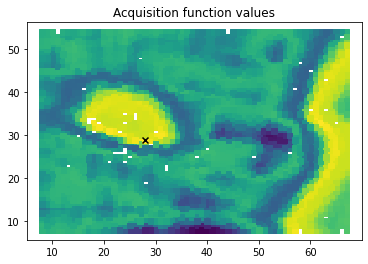

40/80


100%|██████████| 100/100 [00:02<00:00, 35.22it/s, init loss: 20175.7610, avg. loss [96-100]: 19076.1646]



Inferred GP kernel parameters
k_length         [4.274  7.3788]
k_scale          0.23950000000000002
noise            0.0236


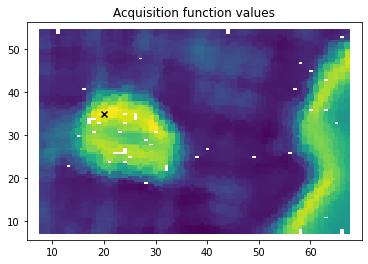

41/80


100%|██████████| 100/100 [00:02<00:00, 35.54it/s, init loss: 20177.1454, avg. loss [96-100]: 19055.0919]



Inferred GP kernel parameters
k_length         [3.7768 3.4122]
k_scale          0.24450000000000002
noise            0.024300000000000002


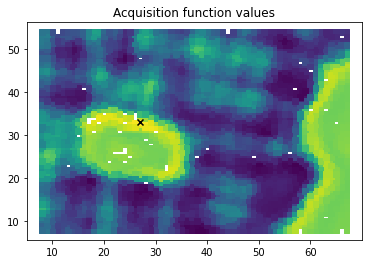

42/80


100%|██████████| 100/100 [00:02<00:00, 35.24it/s, init loss: 20178.4864, avg. loss [96-100]: 19106.0004]



Inferred GP kernel parameters
k_length         [4.8806 7.0941]
k_scale          0.1957
noise            0.0238


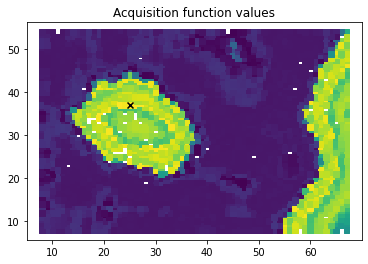

43/80


100%|██████████| 100/100 [00:02<00:00, 35.51it/s, init loss: 20179.7436, avg. loss [96-100]: 19066.4418]



Inferred GP kernel parameters
k_length         [4.4435 4.7989]
k_scale          0.2051
noise            0.022000000000000002


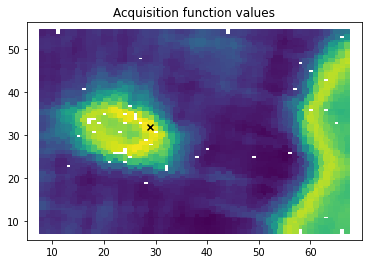

44/80


100%|██████████| 100/100 [00:02<00:00, 34.72it/s, init loss: 20181.1334, avg. loss [96-100]: 19070.0098]



Inferred GP kernel parameters
k_length         [5.9329 3.7116]
k_scale          0.2117
noise            0.023700000000000002


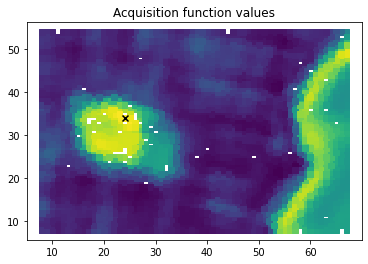

45/80


100%|██████████| 100/100 [00:03<00:00, 31.30it/s, init loss: 20182.4143, avg. loss [96-100]: 19078.8631]



Inferred GP kernel parameters
k_length         [5.5914 6.4867]
k_scale          0.225
noise            0.022500000000000003


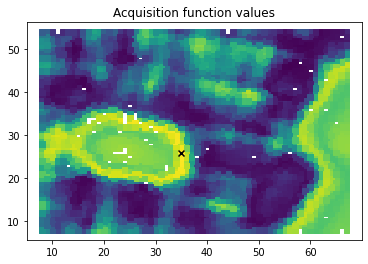

46/80


100%|██████████| 100/100 [00:02<00:00, 34.53it/s, init loss: 20183.6759, avg. loss [96-100]: 19083.8753]



Inferred GP kernel parameters
k_length         [3.2441 2.8112]
k_scale          0.21780000000000002
noise            0.0217


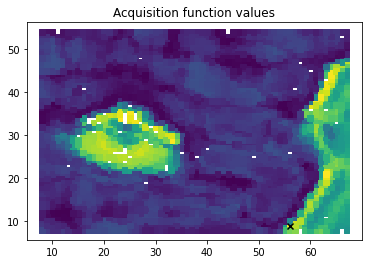

47/80


100%|██████████| 100/100 [00:02<00:00, 35.60it/s, init loss: 20185.0966, avg. loss [96-100]: 19111.4005]



Inferred GP kernel parameters
k_length         [5.9961 4.6834]
k_scale          0.2419
noise            0.0247


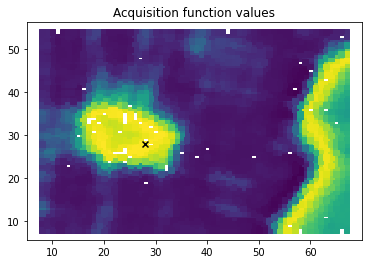

48/80


100%|██████████| 100/100 [00:02<00:00, 34.53it/s, init loss: 20186.4212, avg. loss [96-100]: 19104.1427]



Inferred GP kernel parameters
k_length         [5.7891 5.7749]
k_scale          0.2157
noise            0.024


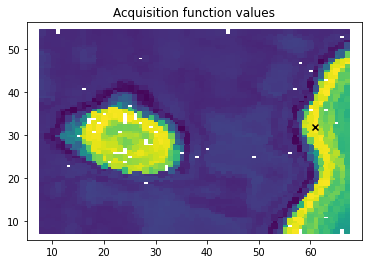

49/80


100%|██████████| 100/100 [00:03<00:00, 30.47it/s, init loss: 20187.7931, avg. loss [96-100]: 19068.5949]



Inferred GP kernel parameters
k_length         [5.6633 6.9806]
k_scale          0.20040000000000002
noise            0.0219


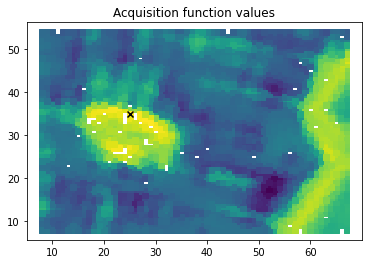

50/80


100%|██████████| 100/100 [00:02<00:00, 34.29it/s, init loss: 20189.1710, avg. loss [96-100]: 19070.9464]



Inferred GP kernel parameters
k_length         [7.2838 3.8605]
k_scale          0.20170000000000002
noise            0.0228


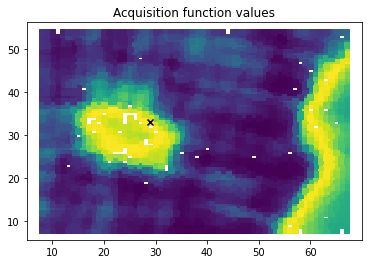

51/80


100%|██████████| 100/100 [00:02<00:00, 35.29it/s, init loss: 20190.4123, avg. loss [96-100]: 19109.6398]



Inferred GP kernel parameters
k_length         [6.0786 5.4732]
k_scale          0.20090000000000002
noise            0.0228


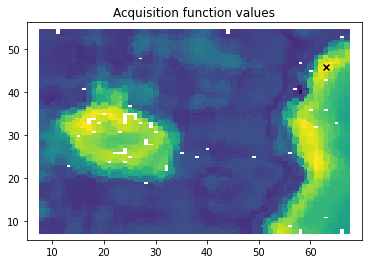

52/80


100%|██████████| 100/100 [00:02<00:00, 34.38it/s, init loss: 20191.6235, avg. loss [96-100]: 19139.8179]



Inferred GP kernel parameters
k_length         [7.5839 6.1764]
k_scale          0.20140000000000002
noise            0.023100000000000002


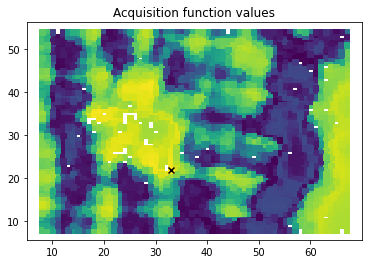

53/80


100%|██████████| 100/100 [00:03<00:00, 30.48it/s, init loss: 20192.9129, avg. loss [96-100]: 19083.5096]



Inferred GP kernel parameters
k_length         [4.3436 3.7979]
k_scale          0.2088
noise            0.019100000000000002


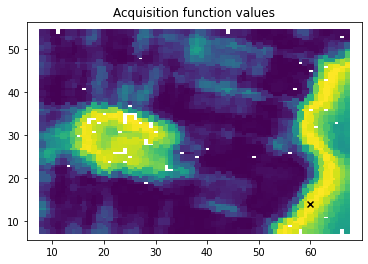

54/80


100%|██████████| 100/100 [00:02<00:00, 34.73it/s, init loss: 20194.2708, avg. loss [96-100]: 19073.4633]



Inferred GP kernel parameters
k_length         [3.8536 5.2725]
k_scale          0.2162
noise            0.020900000000000002


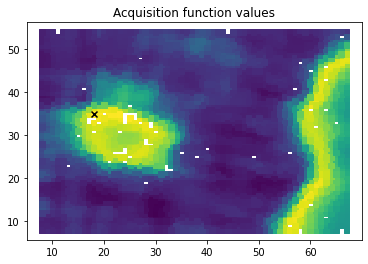

55/80


100%|██████████| 100/100 [00:02<00:00, 34.53it/s, init loss: 20195.5724, avg. loss [96-100]: 19072.7520]



Inferred GP kernel parameters
k_length         [6.934  5.5563]
k_scale          0.19840000000000002
noise            0.019700000000000002


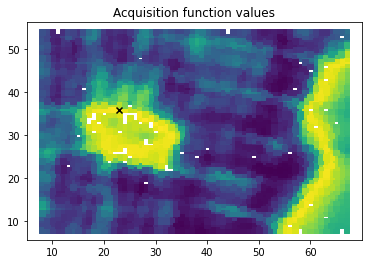

56/80


100%|██████████| 100/100 [00:02<00:00, 34.61it/s, init loss: 20196.9105, avg. loss [96-100]: 19077.0940]



Inferred GP kernel parameters
k_length         [5.0531 4.9222]
k_scale          0.222
noise            0.0213


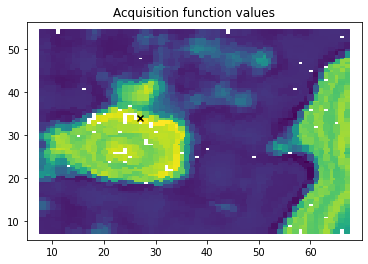

57/80


100%|██████████| 100/100 [00:02<00:00, 34.77it/s, init loss: 20198.1331, avg. loss [96-100]: 19093.3059]



Inferred GP kernel parameters
k_length         [6.0441 4.3706]
k_scale          0.1955
noise            0.018000000000000002


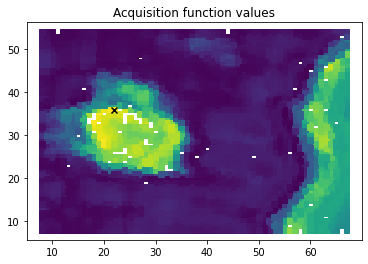

58/80


100%|██████████| 100/100 [00:02<00:00, 34.22it/s, init loss: 20199.3611, avg. loss [96-100]: 19121.7663]



Inferred GP kernel parameters
k_length         [6.1341 5.8753]
k_scale          0.1967
noise            0.0235


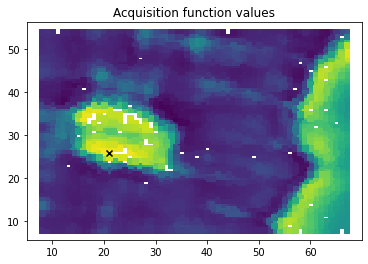

59/80


100%|██████████| 100/100 [00:02<00:00, 35.55it/s, init loss: 20200.6233, avg. loss [96-100]: 19068.8737]



Inferred GP kernel parameters
k_length         [7.0386 8.4956]
k_scale          0.21710000000000002
noise            0.020300000000000002


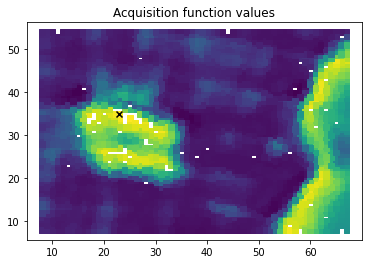

60/80


100%|██████████| 100/100 [00:02<00:00, 33.95it/s, init loss: 20201.9641, avg. loss [96-100]: 19084.0341]



Inferred GP kernel parameters
k_length         [6.2331 7.1148]
k_scale          0.19340000000000002
noise            0.0206


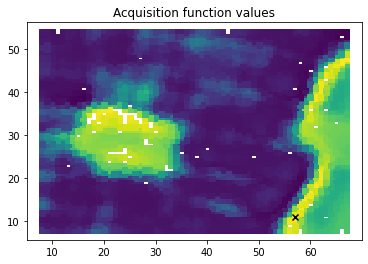

61/80


100%|██████████| 100/100 [00:02<00:00, 35.42it/s, init loss: 20203.2826, avg. loss [96-100]: 19086.2601]



Inferred GP kernel parameters
k_length         [7.2439 6.1959]
k_scale          0.20600000000000002
noise            0.021500000000000002


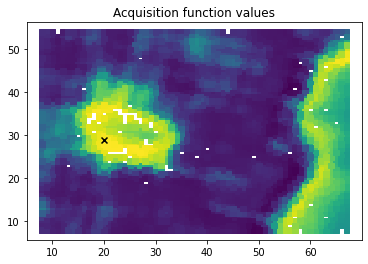

62/80


100%|██████████| 100/100 [00:02<00:00, 33.53it/s, init loss: 20204.4749, avg. loss [96-100]: 19082.3764]



Inferred GP kernel parameters
k_length         [5.4301 7.6045]
k_scale          0.20420000000000002
noise            0.0213


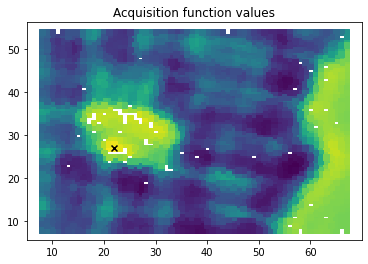

63/80


100%|██████████| 100/100 [00:02<00:00, 35.35it/s, init loss: 20205.6925, avg. loss [96-100]: 19076.1699]



Inferred GP kernel parameters
k_length         [4.1488 5.1038]
k_scale          0.2205
noise            0.0178


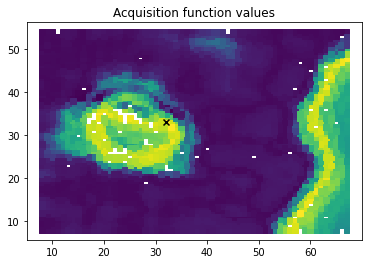

64/80


100%|██████████| 100/100 [00:02<00:00, 34.73it/s, init loss: 20206.9669, avg. loss [96-100]: 19097.1113]



Inferred GP kernel parameters
k_length         [5.27   6.1486]
k_scale          0.1912
noise            0.0212


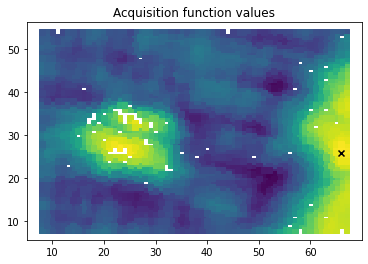

65/80


100%|██████████| 100/100 [00:02<00:00, 35.68it/s, init loss: 20208.1658, avg. loss [96-100]: 19093.2649]



Inferred GP kernel parameters
k_length         [8.4081 5.29  ]
k_scale          0.2187
noise            0.0218


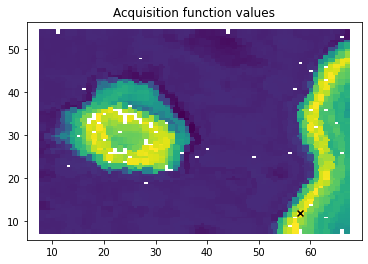

66/80


100%|██████████| 100/100 [00:02<00:00, 34.02it/s, init loss: 20209.4146, avg. loss [96-100]: 19083.9803]



Inferred GP kernel parameters
k_length         [6.4415 7.4525]
k_scale          0.2121
noise            0.0189


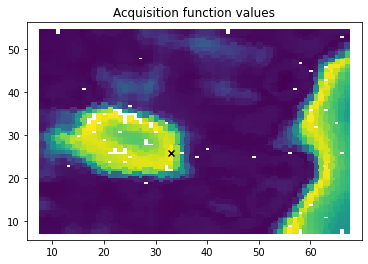

67/80


100%|██████████| 100/100 [00:02<00:00, 34.77it/s, init loss: 20210.6610, avg. loss [96-100]: 19067.4042]



Inferred GP kernel parameters
k_length         [9.5215 6.2354]
k_scale          0.20470000000000002
noise            0.020800000000000003


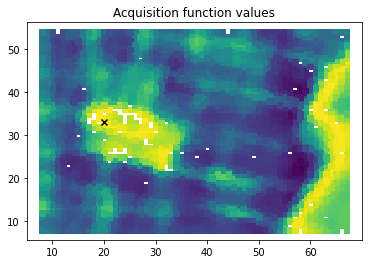

68/80


100%|██████████| 100/100 [00:03<00:00, 29.79it/s, init loss: 20211.9744, avg. loss [96-100]: 19072.5565]



Inferred GP kernel parameters
k_length         [7.2773 6.2591]
k_scale          0.2092
noise            0.0196


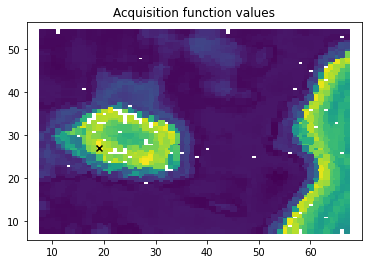

69/80


100%|██████████| 100/100 [00:02<00:00, 35.24it/s, init loss: 20213.1393, avg. loss [96-100]: 19072.3283]



Inferred GP kernel parameters
k_length         [4.8864 5.5537]
k_scale          0.2106
noise            0.016900000000000002


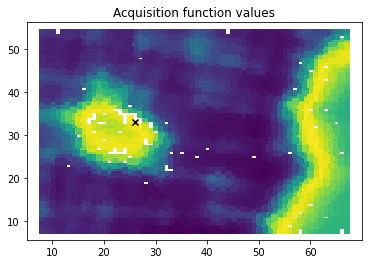

70/80


100%|██████████| 100/100 [00:02<00:00, 35.17it/s, init loss: 20214.4155, avg. loss [96-100]: 19144.9170]



Inferred GP kernel parameters
k_length         [6.742  9.7706]
k_scale          0.1894
noise            0.021500000000000002


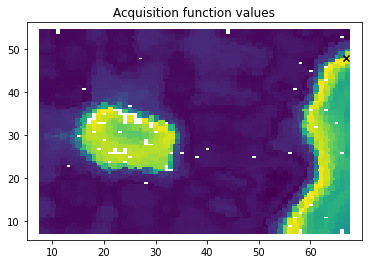

71/80


100%|██████████| 100/100 [00:02<00:00, 35.98it/s, init loss: 20215.6322, avg. loss [96-100]: 19126.4689]



Inferred GP kernel parameters
k_length         [6.8438 7.1658]
k_scale          0.2048
noise            0.02


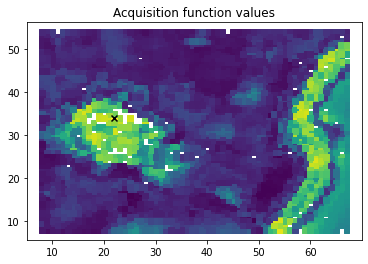

72/80


100%|██████████| 100/100 [00:03<00:00, 30.33it/s, init loss: 20217.0200, avg. loss [96-100]: 19106.1291]



Inferred GP kernel parameters
k_length         [6.1579 8.2017]
k_scale          0.2066
noise            0.0194


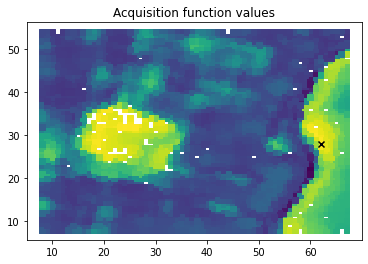

73/80


100%|██████████| 100/100 [00:02<00:00, 35.40it/s, init loss: 20218.3199, avg. loss [96-100]: 19051.3712]



Inferred GP kernel parameters
k_length         [5.5083 6.874 ]
k_scale          0.2094
noise            0.0171


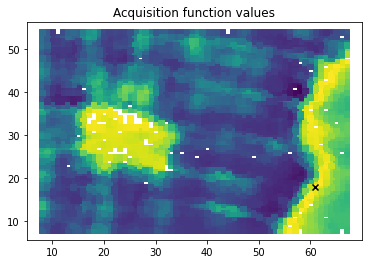

74/80


100%|██████████| 100/100 [00:02<00:00, 34.85it/s, init loss: 20219.6650, avg. loss [96-100]: 19102.8087]



Inferred GP kernel parameters
k_length         [11.193  8.88 ]
k_scale          0.1829
noise            0.0211


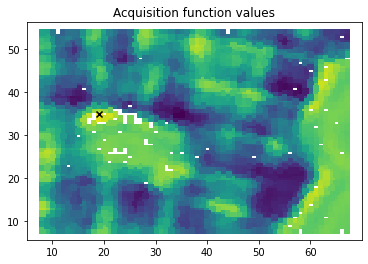

75/80


100%|██████████| 100/100 [00:02<00:00, 35.11it/s, init loss: 20220.8844, avg. loss [96-100]: 19123.0019]



Inferred GP kernel parameters
k_length         [7.3891 9.7313]
k_scale          0.1932
noise            0.020300000000000002


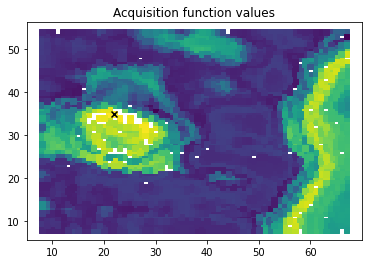

76/80


100%|██████████| 100/100 [00:03<00:00, 30.14it/s, init loss: 20222.1827, avg. loss [96-100]: 19067.9548]



Inferred GP kernel parameters
k_length         [11.5355  7.8789]
k_scale          0.184
noise            0.019100000000000002


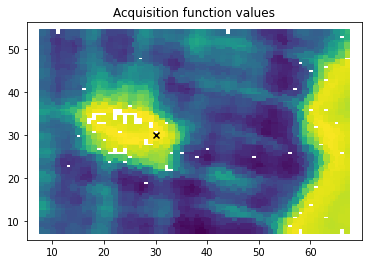

77/80


100%|██████████| 100/100 [00:02<00:00, 35.56it/s, init loss: 20223.5862, avg. loss [96-100]: 19092.5465]



Inferred GP kernel parameters
k_length         [ 6.9861 10.5137]
k_scale          0.18660000000000002
noise            0.0219


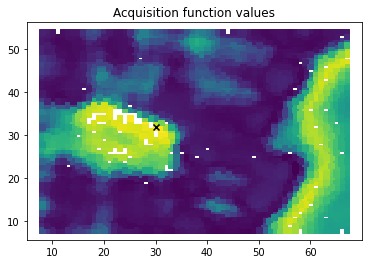

78/80


100%|██████████| 100/100 [00:02<00:00, 35.38it/s, init loss: 20224.7213, avg. loss [96-100]: 19132.7417]



Inferred GP kernel parameters
k_length         [11.5801 14.4903]
k_scale          0.1794
noise            0.020800000000000003


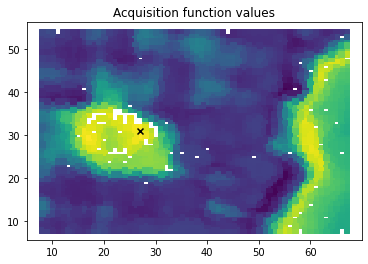

79/80


100%|██████████| 100/100 [00:02<00:00, 35.15it/s, init loss: 20225.9353, avg. loss [96-100]: 19099.9269]



Inferred GP kernel parameters
k_length         [6.4709 6.6405]
k_scale          0.2424
noise            0.018500000000000003


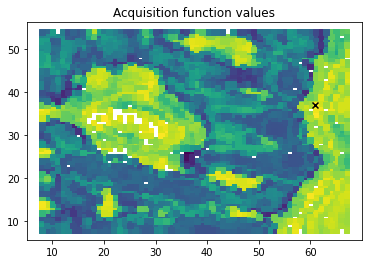

80/80


100%|██████████| 100/100 [00:03<00:00, 30.18it/s, init loss: 20227.2302, avg. loss [96-100]: 19117.5687]



Inferred GP kernel parameters
k_length         [5.784 6.505]
k_scale          0.1898
noise            0.0179


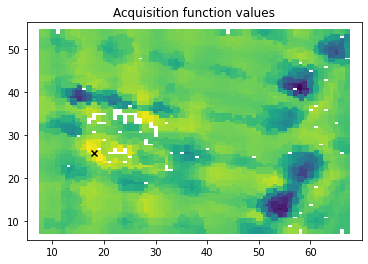

In [ ]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(  # you may decrease step size and increase number of steps (e.g. to 0.005 and 1000) for more stable performance
        key1, X_train, y_train, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_test, beta=0.25, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

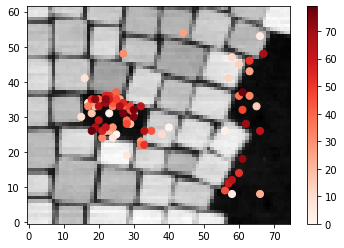

In [ ]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

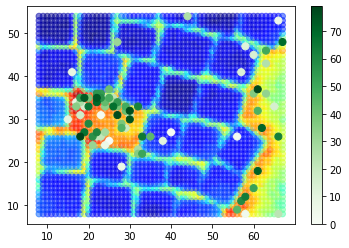

In [ ]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized.